In [26]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
classes = {
    0 : 'angry', 
    1 : 'disgust', 
    2 : 'fear', 
    3 : 'happy', 
    4 : 'neutral', 
    5 : 'sad', 
    6 : 'surprise'
}

In [13]:
curr = os.path.join('datasets/train/train')
directory_contents = os.listdir(curr)
all_data = []
for exp in directory_contents:
    all_images = os.listdir(f'{curr}/{exp}')
    emotion_index = int(list(classes.values()).index(exp))
    data = {'Images' : all_images, 'Label' : emotion_index}
    all_data.append(pd.DataFrame(data))
image_data = pd.concat(all_data, ignore_index=True)
image_data = image_data.sample(frac = 1)
image_data.to_csv(f'datasets/training_images.csv', index=False)

In [14]:
curr = os.path.join('datasets/test/test')
directory_contents = os.listdir(curr)
all_data = []
for exp in directory_contents:
    all_images = os.listdir(f'{curr}/{exp}')
    emotion_index = int(list(classes.values()).index(exp))
    data = {'Images' : all_images, 'Label' : emotion_index}
    all_data.append(pd.DataFrame(data))
image_data = pd.concat(all_data, ignore_index=True)
image_data = image_data.sample(frac = 1)
image_data.to_csv(f'datasets/test_images.csv', index=False)

In [15]:
class CustomImageDataset:
    def __init__(self, csv_file, root_dir, classes, transform=None, target_transform=None) -> None:
        self.annotations = pd.read_csv(f'datasets/{csv_file}')
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = classes
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_index = int(self.annotations.iloc[index, 1])
        exp = self.classes[label_index]
        img_path = os.path.join(f'{self.root_dir}/', 
                                        f'{exp}/{self.annotations.iloc[index, 0]}')
        image = read_image(img_path)
        label = torch.tensor(label_index)
        
        if self.transform:
            image = self.transform(image)
        return (image, label)



In [16]:
training_data = CustomImageDataset('training_images.csv', f'{os.getcwd()}/datasets/train/train', classes)
test_data = CustomImageDataset('test_images.csv', f'{os.getcwd()}/datasets/test/test', classes)

In [17]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 48, 48])
Labels batch shape: torch.Size([64])


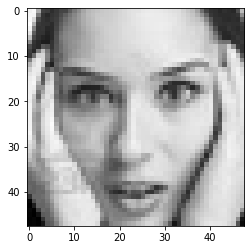

Label: 6 : surprise


In [18]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} : {classes[int(label)]}")

Lets see some of the random images with the labels

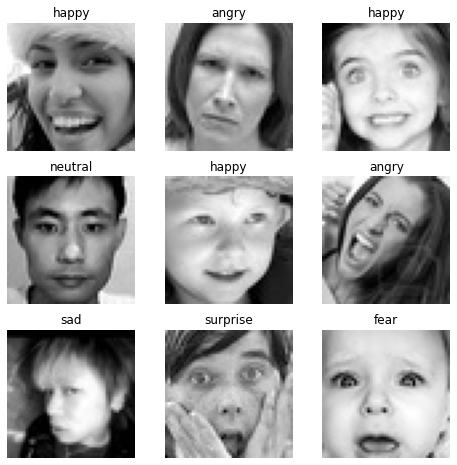

In [19]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Now, we see the distribution of data by different facial expressions

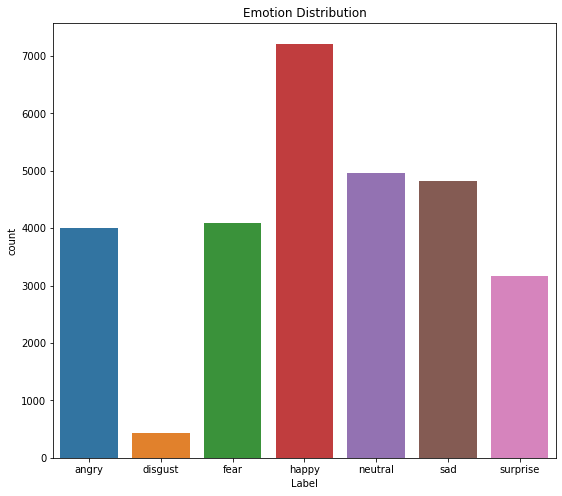

In [20]:
plt.figure(figsize=(9, 8))
ax = sns.countplot(x="Label", data=training_data.annotations)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[classes[i] for i in range(0, 7)], )

Transferring My Model And Data To The GPU Memory

In [23]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cpu')

In [27]:
train_dl = DeviceDataLoader(train_dataloader, device)
test_dl = DeviceDataLoader(test_dataloader, device)

In [28]:
train_dl